## PBL(1): Individual Project Work

1. https://agtechresearch.pythonanywhere.com/ 에 접속하여 회원가입해 주세요. (비밀번호는 단순하게 만드는 것을 권장. 예: 1234)
2. `username` 에 이메일 형식의 아이디를 기입해 주세요.
3. `password` 에 비밀번호를 기입해 주세요.

## PBL(1): Individual Project Work

1. https://agtechresearch.pythonanywhere.com/ 에 접속하여 회원가입해 주세요. (비밀번호는 단순하게 만드는 것을 권장. 예: 1234)
2. `username` 에 이메일 형식의 아이디를 기입해 주세요.
3. `password` 에 비밀번호를 기입해 주세요.

In [67]:
project = "housingprice"  # 수정하지 마세요
username = "g4312@naver.com"  # 회원가입 시 사용한 이메일아이디 (예시. abc@hello.com)
password = "1234"  # 비밀번호

리더보드 제출을 위한 기본 설정: 아래 코드를 실행해주세요.


In [68]:
import os
import urllib.request

if not os.path.exists("competition.py"):
    url = "https://raw.githubusercontent.com/agtechresearch/LectureAlgorithm/main/competition/competition.py"
    filename = "competition.py"
    urllib.request.urlretrieve(url, filename)

아래 코드를 실행하여 데이터를 다운로드 받습니다: 3개의 csv 파일이 data 폴더에 다운로드됨

 * dataset.csv: 과거 주택매매 데이터 -> 학습에 사용할 데이터셋
 * problem.csv: 현재 A사가 매매를 고려하고 있는 130건의 주택정보 -> ML 모델에 의하여 예측을 수행하여야 할 데이터셋
 * submission.csv: 리더보드 서버 제출을 위한 파일 형식


In [69]:
import competition

# 파일 다운로드
competition.download_competition_files(project)

100%|██████████| 141k/141k [00:00<00:00, 358kiB/s] 


In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# 경고 무시
warnings.filterwarnings("ignore")

# Data 경로 설정
DATA_DIR = "data"

In [71]:
# 학습에 사용할 과거 주택매매 data set 로드 (dataset.csv)
dataset = pd.read_csv(os.path.join(DATA_DIR, "dataset.csv"))

# problem set 로드 (problem.csv)
problemset = pd.read_csv(os.path.join(DATA_DIR, "problem.csv"))

In [72]:
# # 결측치가 있다면 GarageType은 NO Garage로, GarageYrBlt의 값은 0으로 대체
dataset["GarageType"].fillna("No Garage", inplace=True)
dataset["GarageYrBlt"].fillna(0, inplace=True)

dataset.isnull().sum()


Id              0
LotArea         0
Street          0
LotConfig       0
OverallQual     0
OverallCond     0
YearBuilt       0
YearRemodAdd    0
TotalBsmtSF     0
1stFlrSF        0
2ndFlrSF        0
GrLivArea       0
FullBath        0
HalfBath        0
BedroomAbvGr    0
KitchenAbvGr    0
TotRmsAbvGrd    0
Fireplaces      0
GarageType      0
GarageYrBlt     0
GarageCars      0
GarageArea      0
YrSold          0
SalePrice       0
dtype: int64

##### 전처리

GirLivArea와 TtoRmsABgred 즉 지상 거실 면적 평방 피트와 지하층 위의 모든 방은 0.8의 관계
FullBath와 HalfBath를 합쳐서 Bath로 만든다
YearBuilt는 제거하고, 2024를 YearRemodAdd뺀 Year 열 추가, 이후 YearRemodAdd는 제거
총 면적을 나타내기 위해 1stFlrSF, 2ndFlrSF, TotalBsmtSF를 합쳐서 TotalFlr로 나타낸다. 나머지는 지운다
Id제거, KitchenAbvGr제거, YrSold제거


In [73]:
#FullBath와 HalfBath를 합쳐서 Bath로 만든다
#YearBuilt는 제거하고, 2024를 YearRemodAdd뺀 Year 열 추가, 이후 YearRemodAdd는 제거
#총 면적을 나타내기 위해 1stFlrSF, 2ndFlrSF, TotalBsmtSF를 합쳐서 TotalFlr로 나타낸다. 나머지는 지운다
#OverallCond제거, Id제거, KitchenAbvGr제거, YrSold제거

dataset["Bath"] = dataset["FullBath"] + dataset["HalfBath"]
dataset["Year"] = 2024 - dataset["YearRemodAdd"]
dataset["TotalFlr"] = dataset["1stFlrSF"] + dataset["2ndFlrSF"] + dataset["TotalBsmtSF"]

#이후 필요없는 열 제거
dataset.drop(["FullBath", "HalfBath", "YearBuilt", "YearRemodAdd", "1stFlrSF", "2ndFlrSF", "TotalBsmtSF",  "Id", "KitchenAbvGr", "YrSold"], axis=1, inplace=True)



In [74]:
# # problem set 전처리
# # problem set에도 동일한 전처리를 적용한다.
problemset["Bath"] = problemset["FullBath"] + problemset["HalfBath"]
problemset["Year"] = 2024 - problemset["YearRemodAdd"]
problemset["TotalFlr"] = problemset["1stFlrSF"] + problemset["2ndFlrSF"] + problemset["TotalBsmtSF"]
#이후 필요없는 열 제거
problemset.drop(["FullBath", "HalfBath", "YearBuilt", "YearRemodAdd", "1stFlrSF", "2ndFlrSF", "TotalBsmtSF", "Id", "KitchenAbvGr", "YrSold"], axis=1, inplace=True)


In [75]:
dataset.columns,problemset.columns

(Index(['LotArea', 'Street', 'LotConfig', 'OverallQual', 'OverallCond',
        'GrLivArea', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageType',
        'GarageYrBlt', 'GarageCars', 'GarageArea', 'SalePrice', 'Bath', 'Year',
        'TotalFlr'],
       dtype='object'),
 Index(['LotArea', 'Street', 'LotConfig', 'OverallQual', 'OverallCond',
        'GrLivArea', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageType',
        'GarageYrBlt', 'GarageCars', 'GarageArea', 'Bath', 'Year', 'TotalFlr'],
       dtype='object'))

In [76]:
# Steet, LotConfig, Garagetype은 범주형

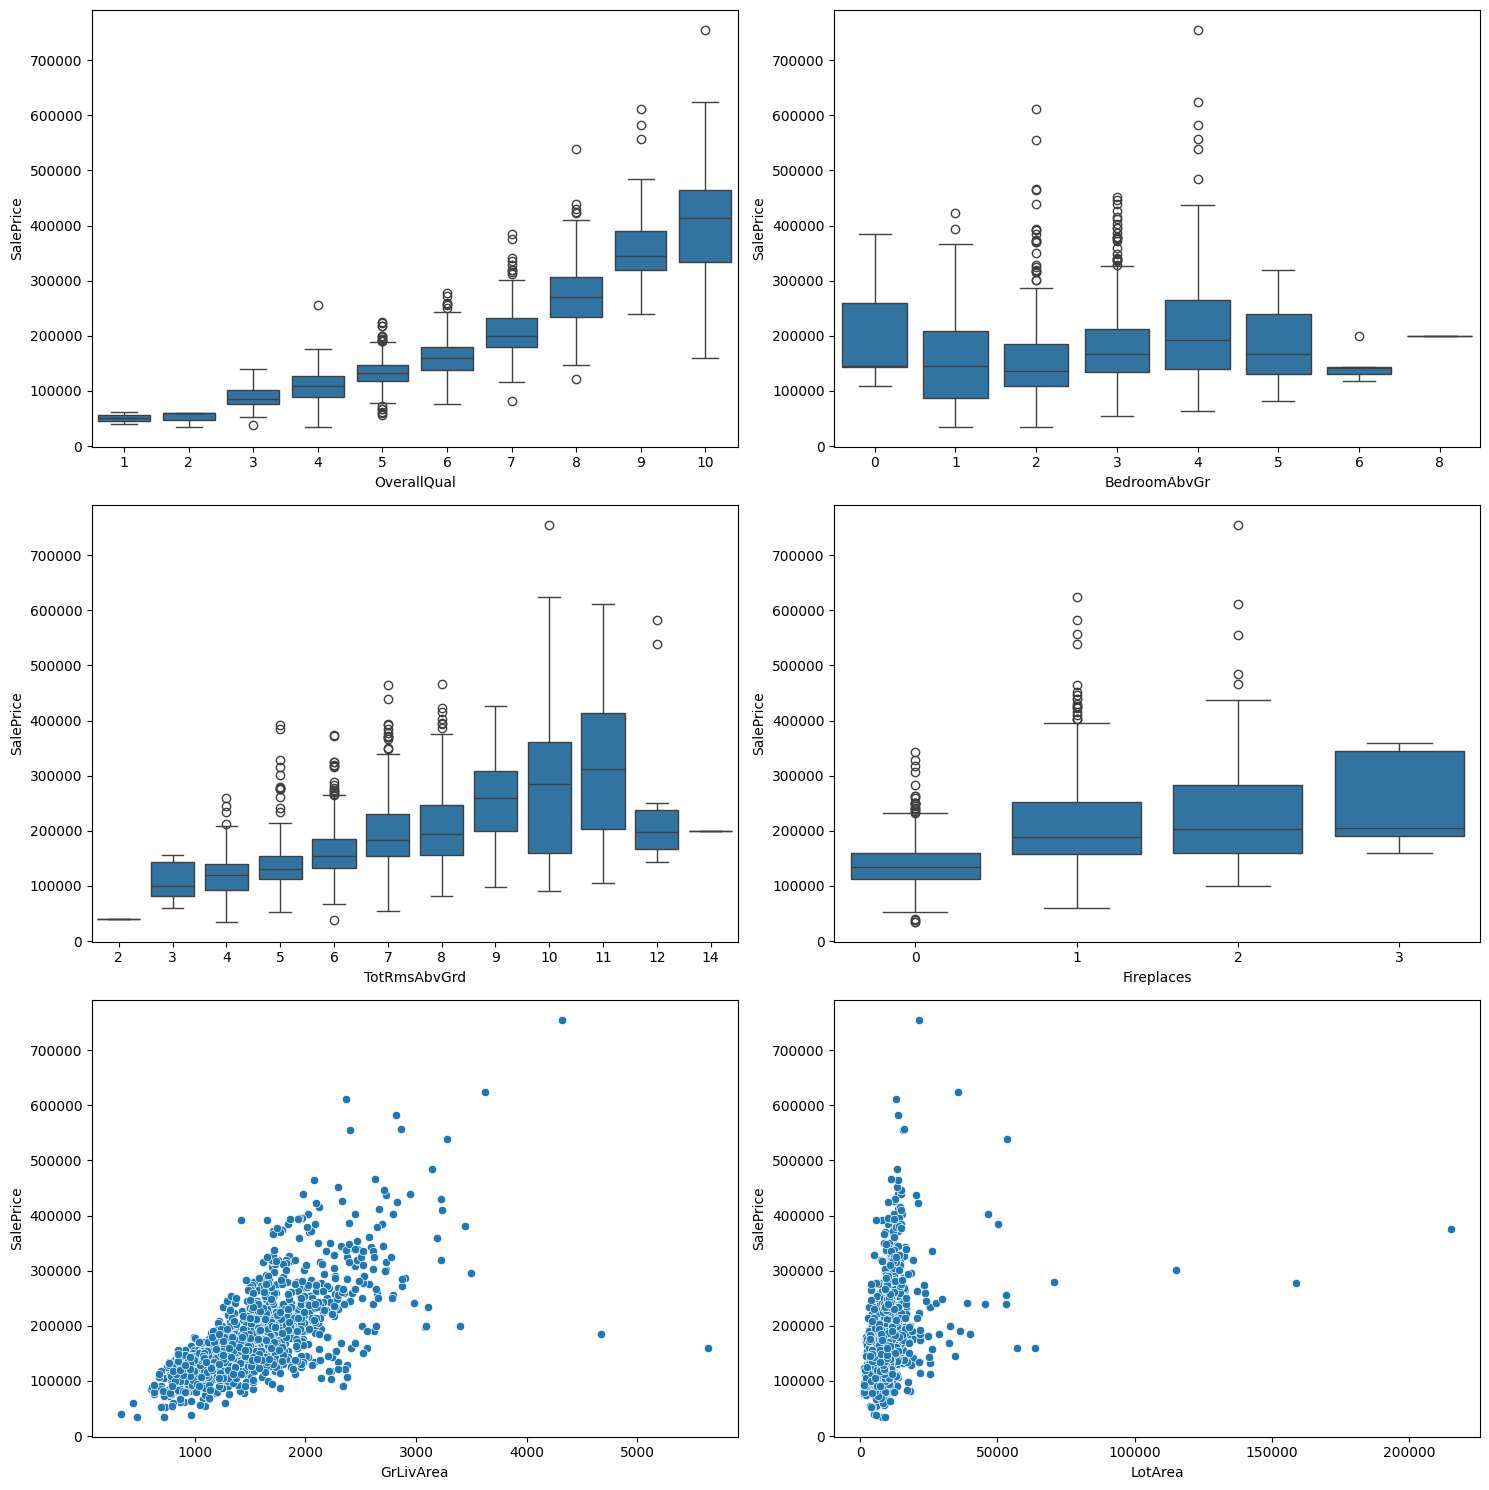

In [77]:
#LotArea', 'OverallQual', 'GrLivArea','BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces'과  SalePrice와의 관계 시각화
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
# 전부 boxplot으로 시각화
sns.boxplot(x="OverallQual", y="SalePrice", data=dataset, ax=ax[0, 0])
sns.boxplot(x="BedroomAbvGr", y="SalePrice", data=dataset, ax=ax[0, 1])
sns.boxplot(x="TotRmsAbvGrd", y="SalePrice", data=dataset, ax=ax[1, 0])
sns.boxplot(x="Fireplaces", y="SalePrice", data=dataset, ax=ax[1, 1])
sns.scatterplot(x="GrLivArea", y="SalePrice", data=dataset, ax=ax[2, 0])
sns.scatterplot(x="LotArea", y="SalePrice", data=dataset, ax=ax[2, 1])
plt.tight_layout()
plt.show()

In [78]:
# GrLIvArea가 4000이상인 이상치 4000으로 대체
dataset.loc[dataset["GrLivArea"] > 4000, "GrLivArea"] = 4000
# LotArea가 100000이상인 이상치 100000으로 대체
dataset.loc[dataset["LotArea"] > 100000, "LotArea"] = 100000


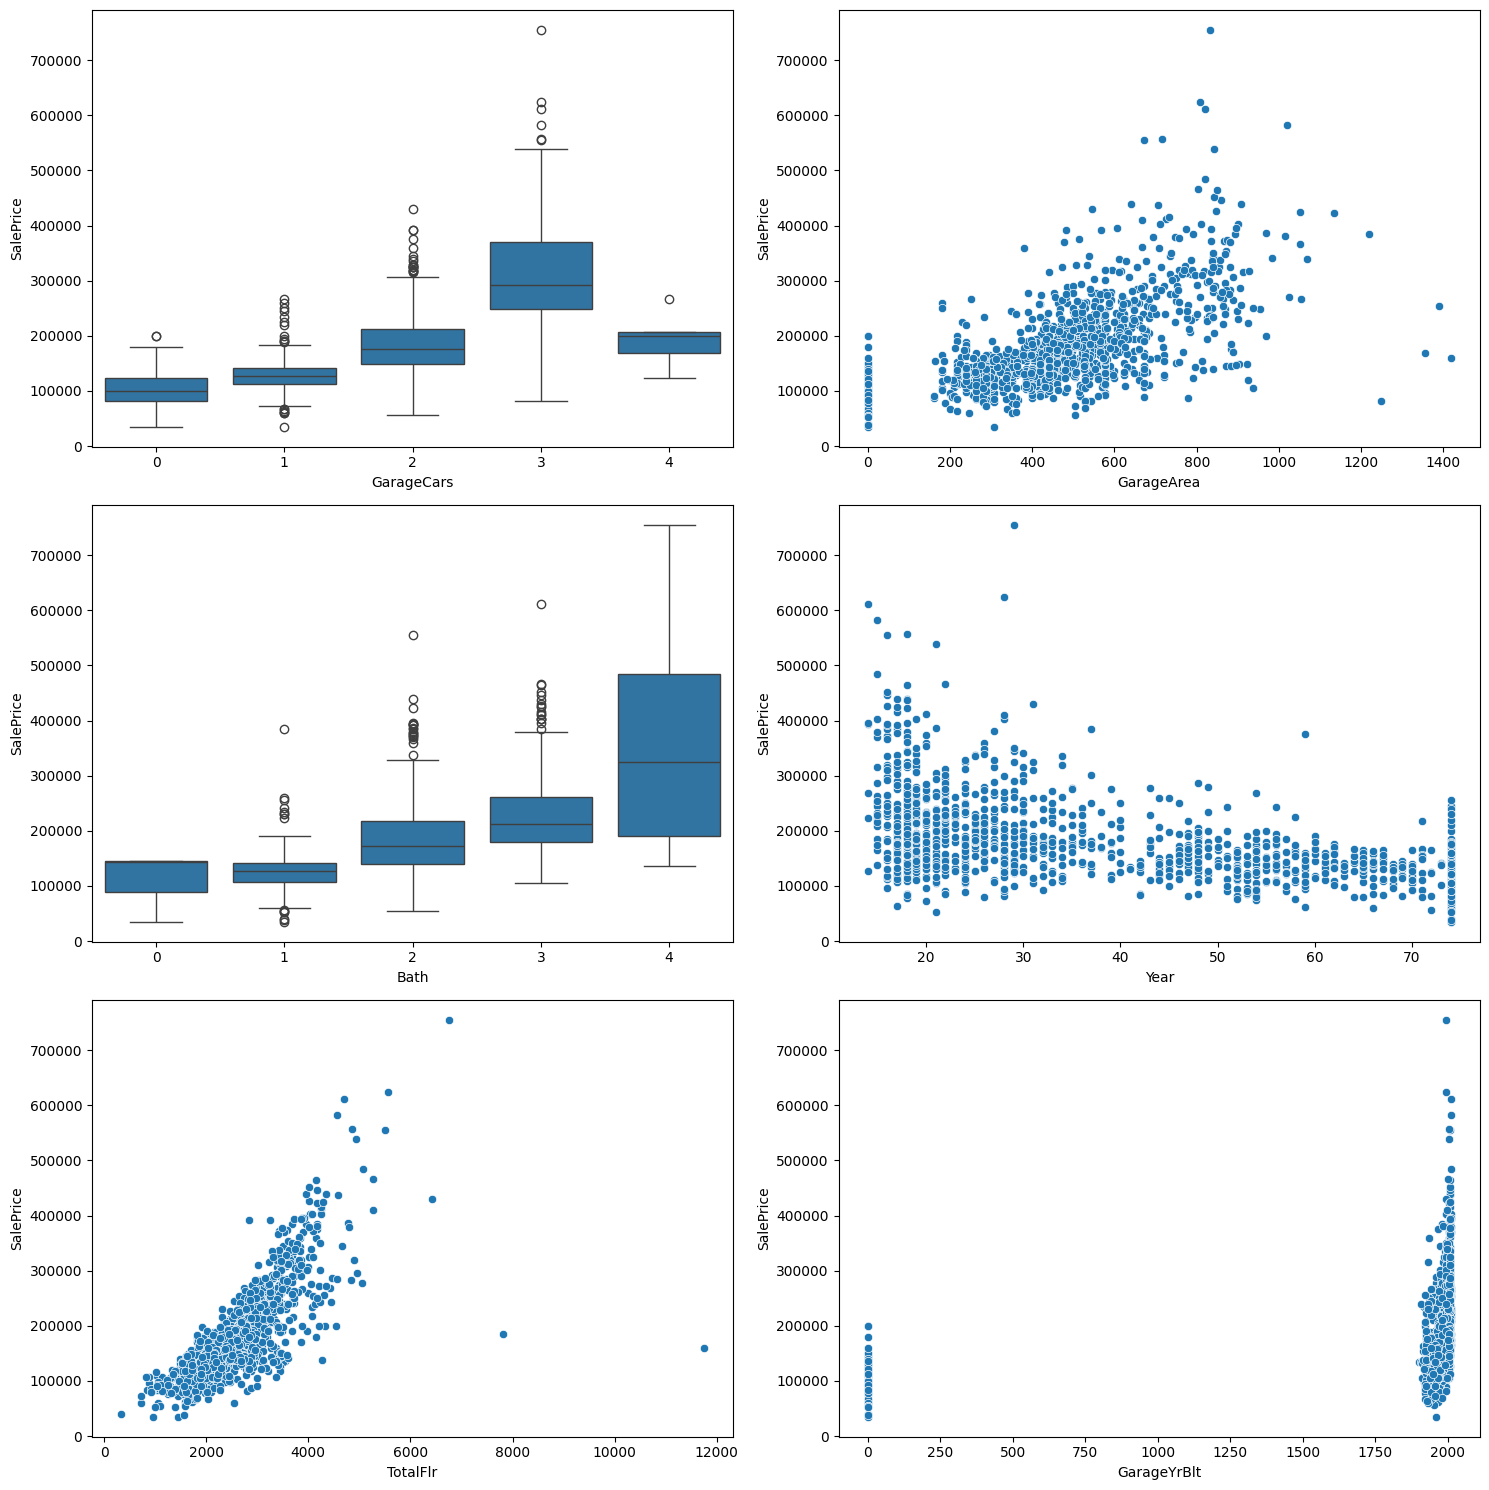

In [79]:
#GarageYrBlt', 'GarageCars', 'GarageArea','Bath', 'Year','TotalFlr'과 SalePrice와의 관계 시각화
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
# 전부 boxplot으로 시각화
sns.boxplot(x="GarageCars", y="SalePrice", data=dataset, ax=ax[0, 0])
sns.scatterplot(x="GarageArea", y="SalePrice", data=dataset, ax=ax[0, 1])
sns.boxplot(x="Bath", y="SalePrice", data=dataset, ax=ax[1, 0])
sns.scatterplot(x="Year", y="SalePrice", data=dataset, ax=ax[1, 1])
sns.scatterplot(x="TotalFlr", y="SalePrice", data=dataset, ax=ax[2, 0])
sns.scatterplot(x="GarageYrBlt", y="SalePrice", data=dataset, ax=ax[2, 1])
plt.tight_layout()
plt.show()


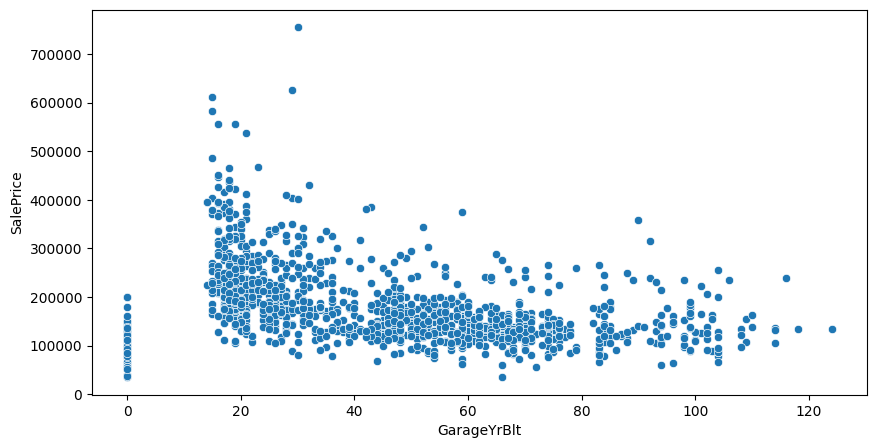

In [80]:
# GarageYrBlt가 0이 아닐시 2024에서 뺀 값으로 대체
dataset.loc[dataset["GarageYrBlt"] != 0, "GarageYrBlt"] = 2024 - dataset["GarageYrBlt"]
# problem set에도 동일한 전처리를 적용한다.
problemset.loc[problemset["GarageYrBlt"] != 0, "GarageYrBlt"] = 2024 - problemset["GarageYrBlt"]
# 이후 GarageYrBlt 시각화
plt.figure(figsize=(10, 5))
sns.scatterplot(x="GarageYrBlt", y="SalePrice", data=dataset)   
plt.show()





In [81]:
dataset.describe()

,LotArea,OverallQual,OverallCond,GrLivArea,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,SalePrice,Bath,Year,TotalFlr
count,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.00000,1340.000000,1340.000000,1340.000000,1340.000000
mean,10253.350000,6.085821,5.578358,1506.765672,2.866418,6.517164,0.607463,42.881343,1.750746,468.71791,179731.313433,1.940299,39.286567,2556.946269
std,7079.279267,1.382471,1.113691,511.225212,0.819428,1.627482,0.640625,26.228646,0.755734,215.18436,78153.434985,0.798254,20.645194,824.304898
min,1300.000000,1.000000,1.000000,334.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.00000,34900.000000,0.000000,14.000000,334.000000
25%,7500.000000,5.000000,5.000000,1121.750000,2.000000,5.000000,0.000000,21.000000,1.000000,319.50000,129500.000000,1.000000,20.000000,1998.750000
50%,9468.500000,6.000000,5.000000,1456.000000,3.000000,6.000000,1.000000,40.000000,2.000000,476.50000,161250.000000,2.000000,31.000000,2460.000000
75%,11515.500000,7.000000,6.000000,1775.250000,3.000000,7.000000,1.000000,62.000000,2.000000,576.00000,213000.000000,3.000000,57.250000,2990.250000
max,100000.000000,10.000000,9.000000,4000.000000,8.000000,14.000000,3.000000,124.000000,4.000000,1418.00000,755000.000000,4.000000,74.000000,11752.000000


In [82]:
# shape 확인
dataset.shape, problemset.shape

((1340, 17), (130, 16))

In [83]:
# street 열 제거
dataset.drop("Street", axis=1, inplace=True)
problemset.drop("Street", axis=1, inplace=True)

전처리 끝

In [84]:
# 데이터셋을 학습용과 test로 나눈다
from sklearn.model_selection import train_test_split
X = dataset.drop("SalePrice", axis=1)
y = dataset["SalePrice"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [98]:
# 범주형 변수 모두 one-hot encoding
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
problemset = pd.get_dummies(problemset)



In [99]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# 수치형 변수와 범주형 변수를 구분
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

# 전처리 파이프라인 정의
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Pipeline 정의
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# train 데이터셋에 Pipeline 적용
x_train_preprocessed = pipeline.fit_transform(X_train)

# test 및 problem 데이터셋에 Pipeline 적용
x_test_preprocessed = pipeline.transform(X_test)
x_problem_preprocessed = pipeline.transform(problemset)


In [100]:
# lightgbm 모델 학습
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
lgb = lgb.LGBMRegressor()
lgb.fit(x_train_preprocessed, y_train)



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1221
[LightGBM] [Info] Number of data points in the train set: 1072, number of used features: 13
[LightGBM] [Info] Start training from score 179921.842351


LGBMRegressor()

In [101]:
from sklearn.metrics import mean_squared_error

train_pred = lgb.predict(x_train_preprocessed)
test_pred = lgb.predict(x_test_preprocessed)

print("Train RMSE :", mean_squared_error(y_train, train_pred) ** 0.5)
print("Test RMSE :", mean_squared_error(y_test, test_pred) ** 0.5)

Train RMSE : 16113.443773574056
Test RMSE : 30742.72862101786


In [91]:
problem_pred = lgb.predict(x_problem_preprocessed)

In [92]:
# 리더보드 서버 제출을 위한 파일 생성
submission = pd.read_csv(os.path.join(DATA_DIR, "submission.csv"))
submission["SalePrice"] = problem_pred

# 예측 결과 화면에 출력 후 제출
display(submission)
competition.submit(project, username, password, submission)

,Id,SalePrice
0,1341,124226.082887
1,1342,131993.245307
2,1343,168433.985841
3,1344,132211.211988
4,1345,118759.207612
...,...,...
125,1466,311868.984722
126,1467,205368.079983
127,1468,78966.841427
128,1469,96918.101673


아이디:  g4312@naver.com
파일명:  submissions\20240514-141538-submission.csv
[제출에 성공하였습니다]
제출 결과: 31627.754674249056
